<a href="https://colab.research.google.com/github/shaon11579/DNN-fall-2021/blob/main/Assignment_5_code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

In [4]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data(label_mode='fine')

TypeError: ignored

# lec 18 code 

In [7]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [8]:
## Download the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
## normalize and reshape
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

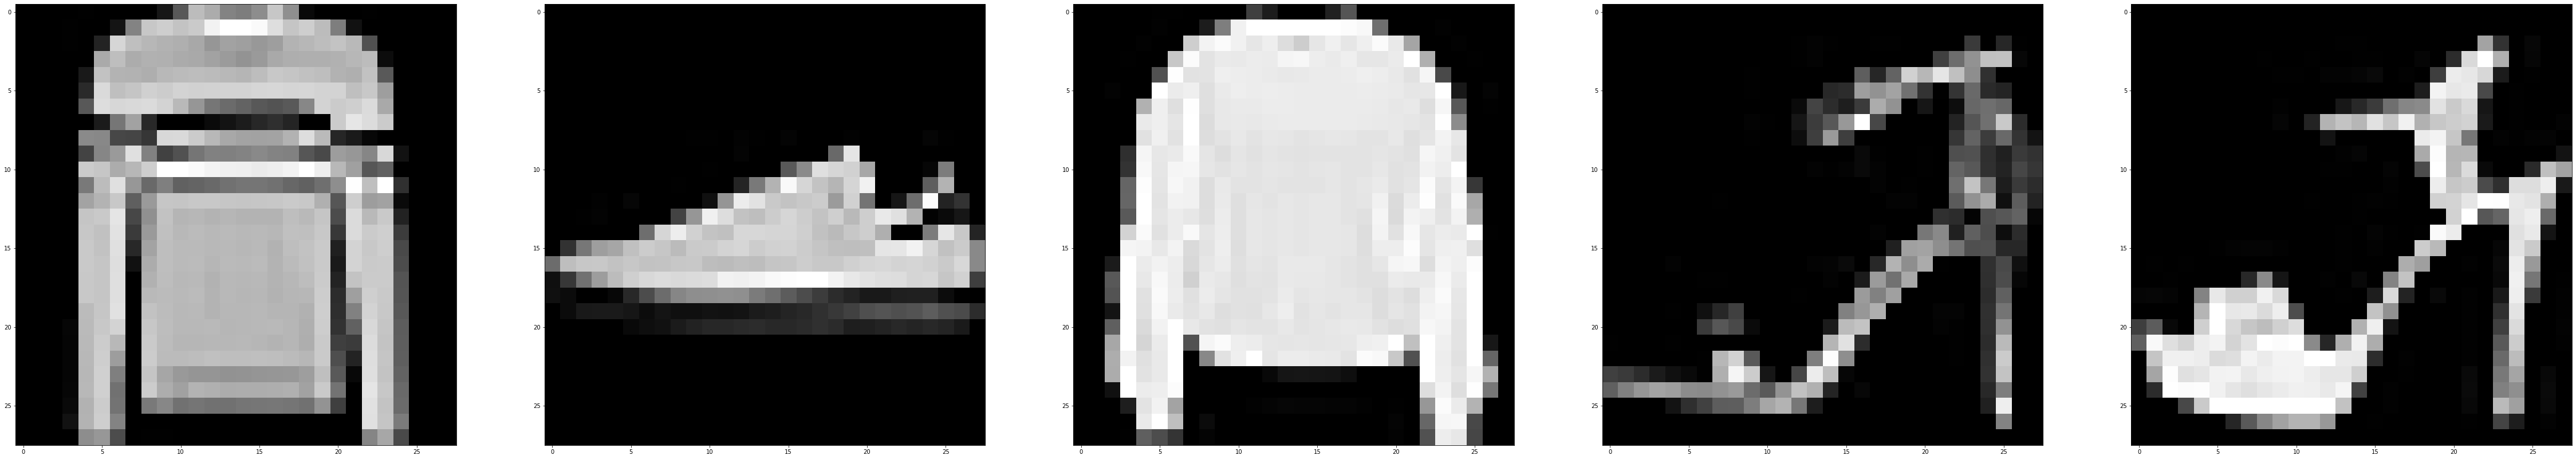

In [11]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(x_train[i, :, :, 0].reshape(28, 28))

# Part 2: Denoise Images using AEs

In [12]:
![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

/bin/bash: -c: line 0: syntax error near unexpected token `https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png'
/bin/bash: -c: line 0: `[Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)'


In [13]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(x_train * 255) / 255
val_x_n = seq_object.augment_images(x_test * 255) / 255

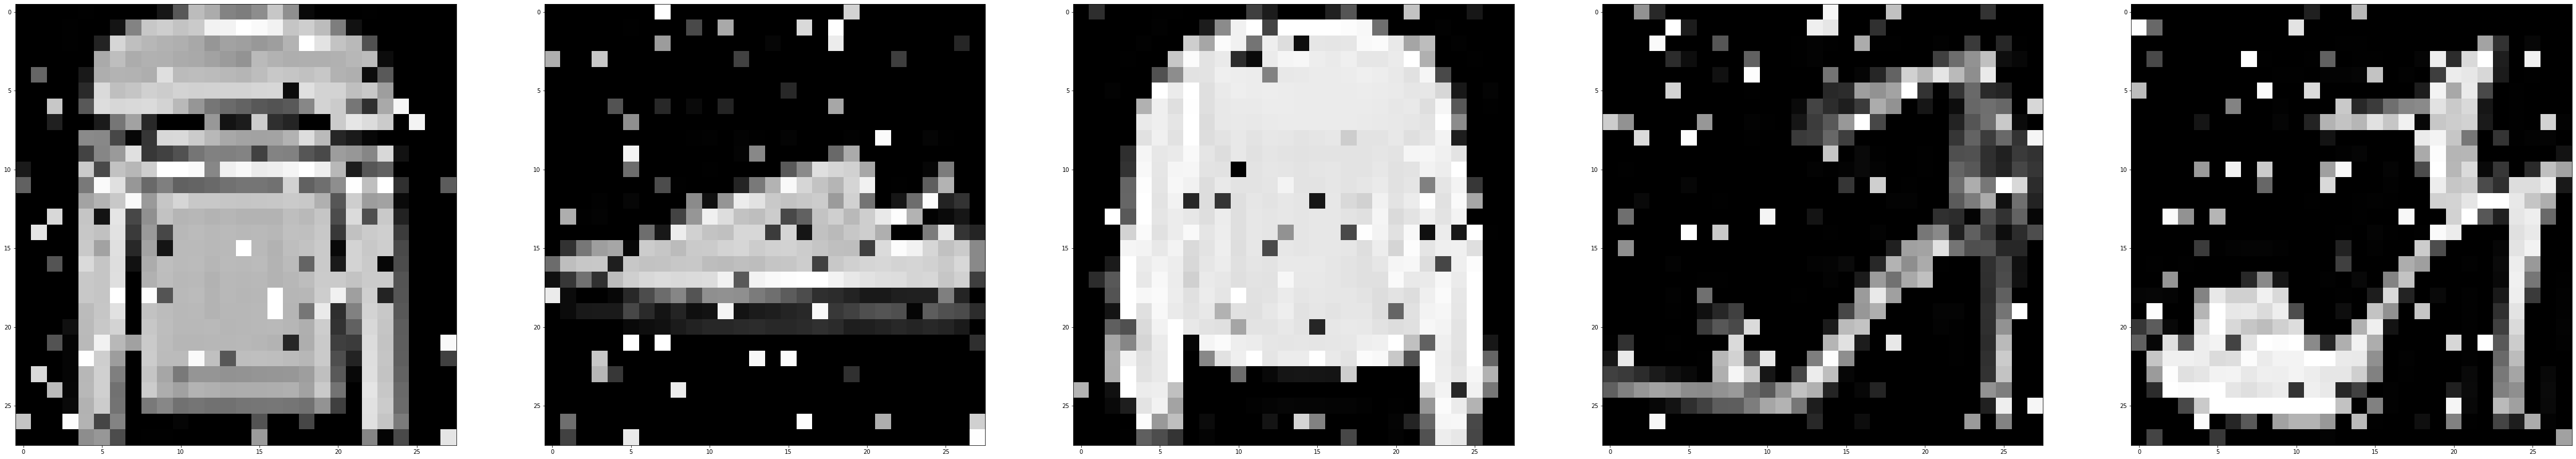

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

# Design the network

In [15]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

In [16]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

In [17]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, x_train, epochs=20, batch_size=2048, validation_data=(val_x_n, x_test), callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 19s 92ms/step - loss: 0.0896 - val_loss: 0.0471
Epoch 2/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0407 - val_loss: 0.0352
Epoch 3/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0320 - val_loss: 0.0288
Epoch 4/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0273 - val_loss: 0.0259
Epoch 5/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 6/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 7/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0219 - val_loss: 0.0213
Epoch 8/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 9/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0203 - val_loss: 0.0200
Epoch 10/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 11

# Visualize Samples reconstructed by AE
# Testing standard images

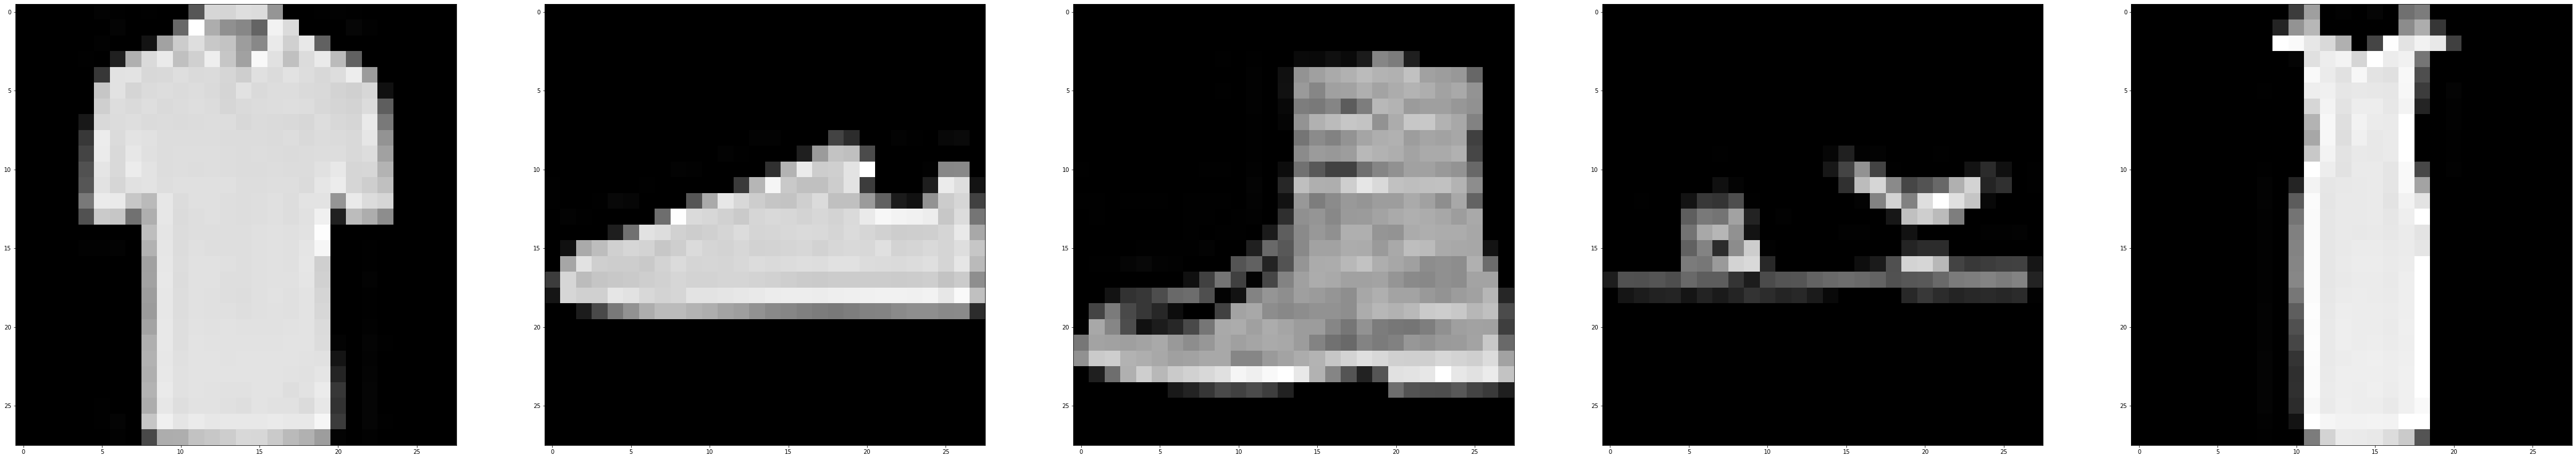

In [20]:
n = np.random.randint(0,len(x_test)-5)

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(x_test[a, :, :, 0].reshape(28, 28))

# Noisy images

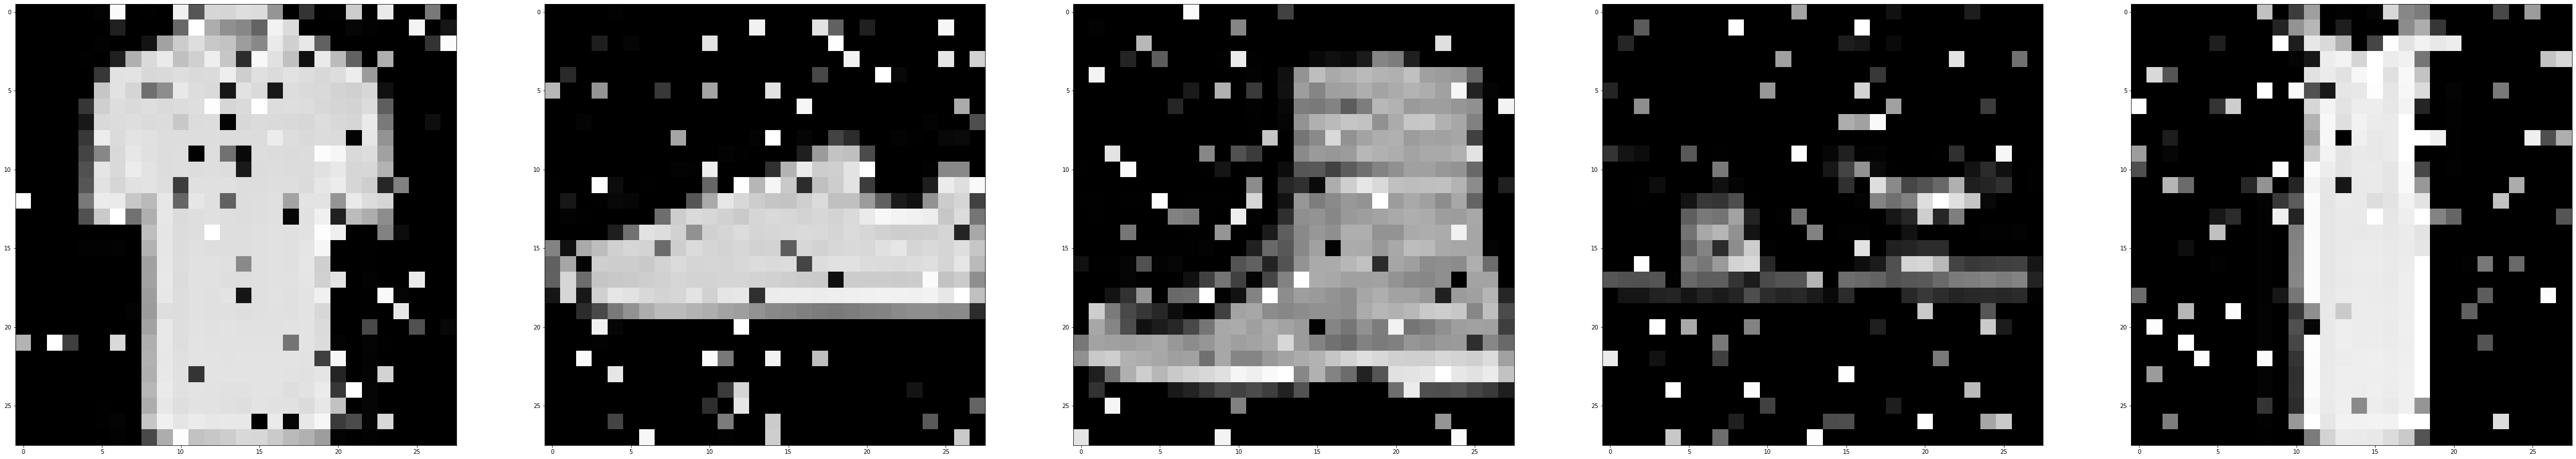

In [21]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

# Images after denoising

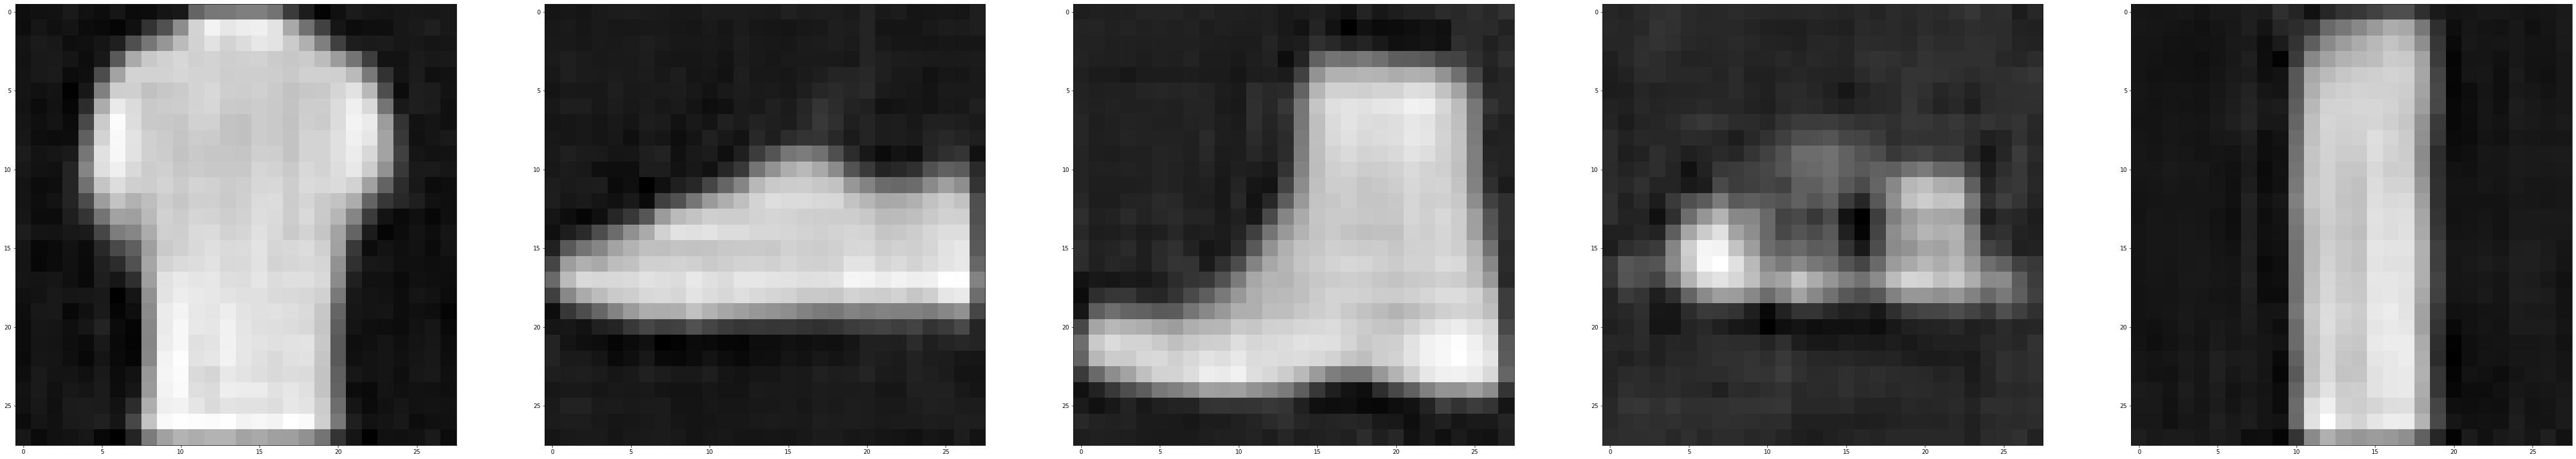

In [22]:
preds = model.predict(val_x_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

# Show intermediate results

In [23]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

In [24]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

(5, 4, 4, 16)

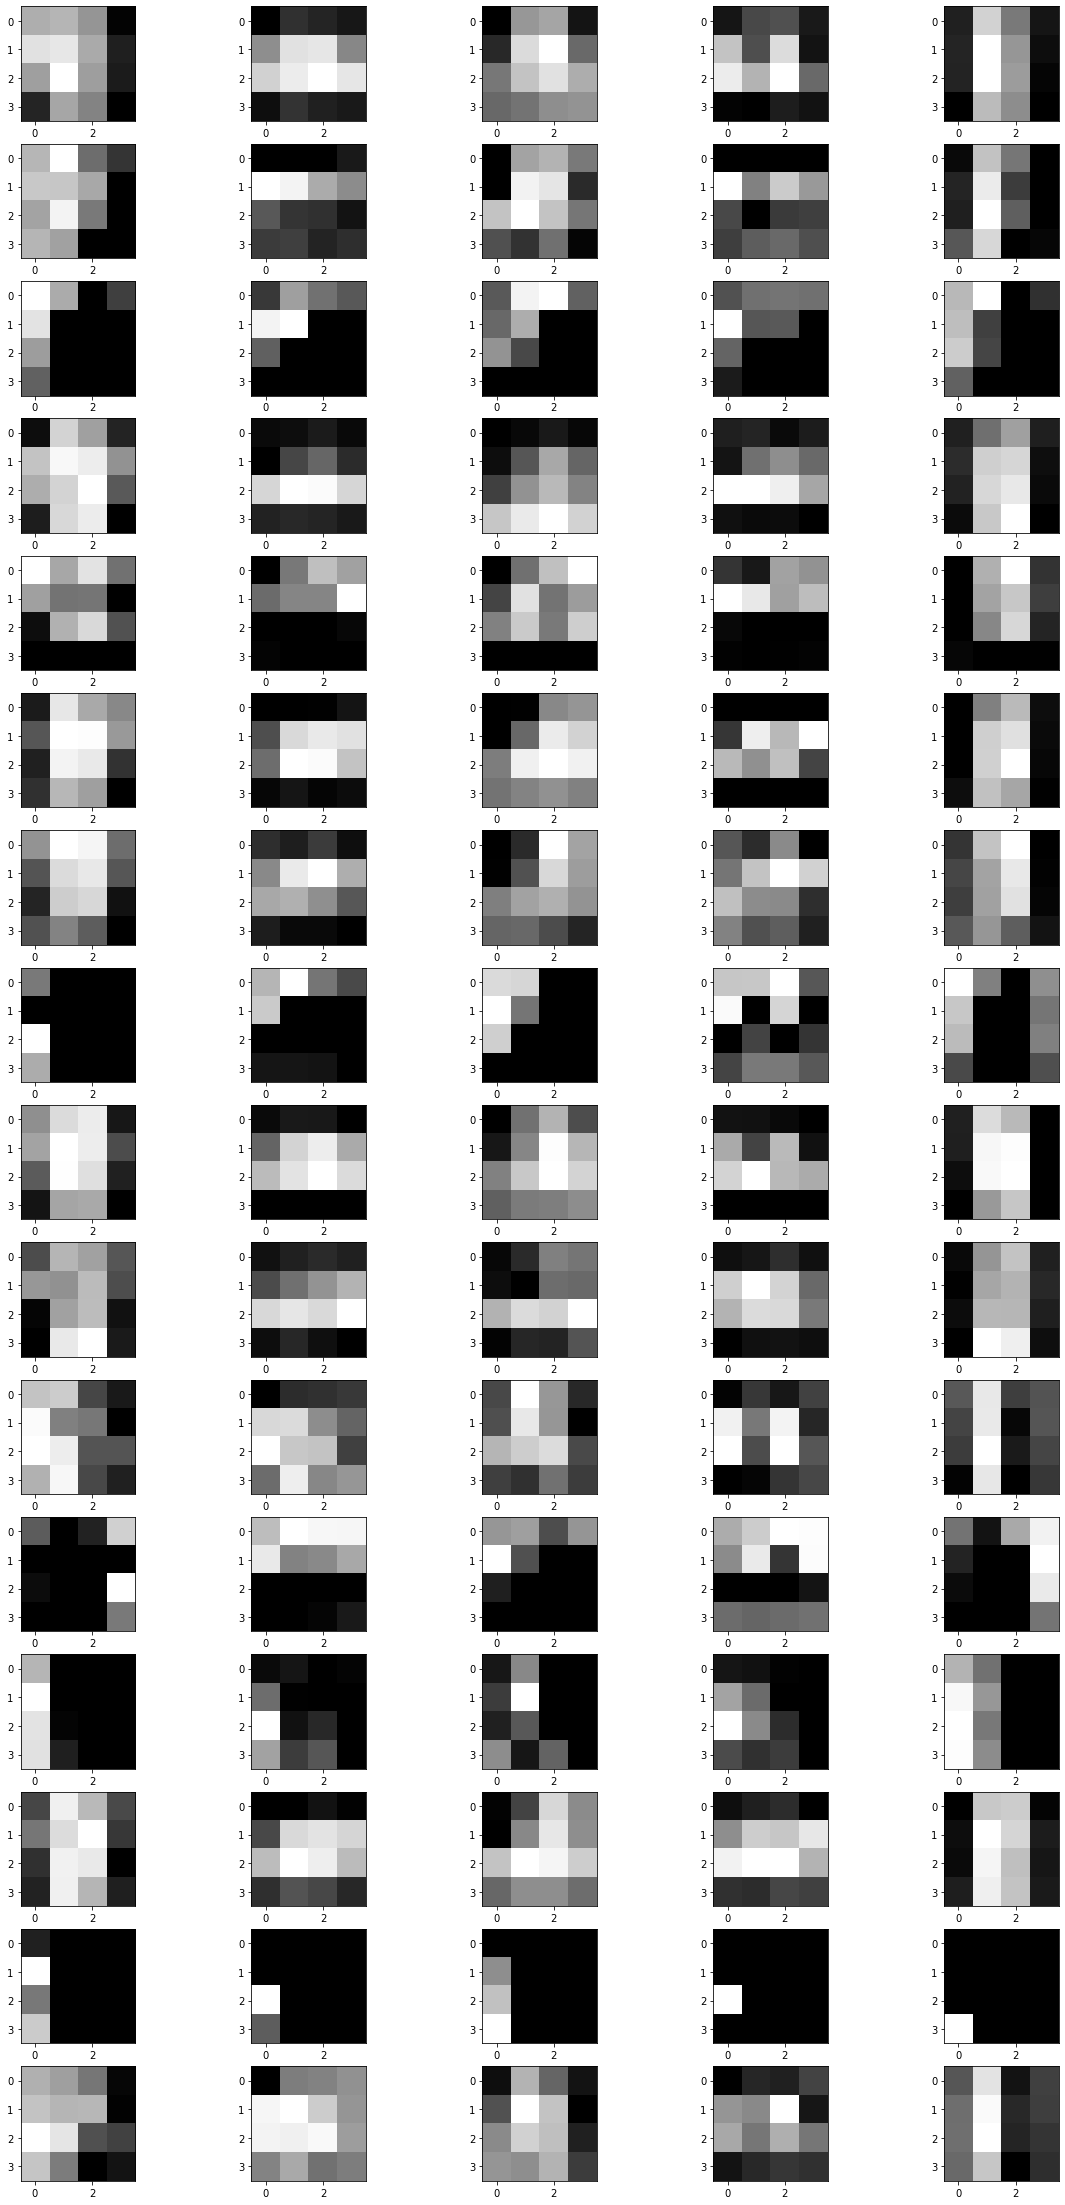

In [25]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()

# lec 19

# Part 2: Generating New Fashion using VAEs

In [28]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt

# Understanding VAE
# load dataset

In [29]:
### read dataset 
## Download the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

train_x = x_train
val_x = x_test

In [30]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

# Setup Encoder Neural Network

In [31]:
import keras.backend as K

In [32]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [33]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [34]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [35]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dense  (None, 512)              1536      
 )                                                               
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [36]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [37]:
z_decoded

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_2')>

In [38]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [39]:
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 intermediate_encoder (Dense)   (None, 512)          401920      ['input[0][0]']                  
                                                                                                  
 latent_encoder (Dense)         (None, 2)            1026        ['intermediate_encoder[0][0]']   
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['latent_encoder[0][0]']         
                                                                                            

In [40]:
train_x.shape

(60000, 28, 28, 1)

In [41]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [42]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Epoch 1/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3803 - val_loss: 0.3509
Epoch 2/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3443 - val_loss: 0.3493
Epoch 3/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3372 - val_loss: 0.3370
Epoch 4/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3340 - val_loss: 0.3342
Epoch 5/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3319 - val_loss: 0.3329
Epoch 6/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3307 - val_loss: 0.3303
Epoch 7/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3299 - val_loss: 0.3307
Epoch 8/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3291 - val_loss: 0.3292
Epoch 9/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3286 - val_loss: 0.3299
Epoch 10/20
3750/3750 [==============================] - 11s 3ms/step - l

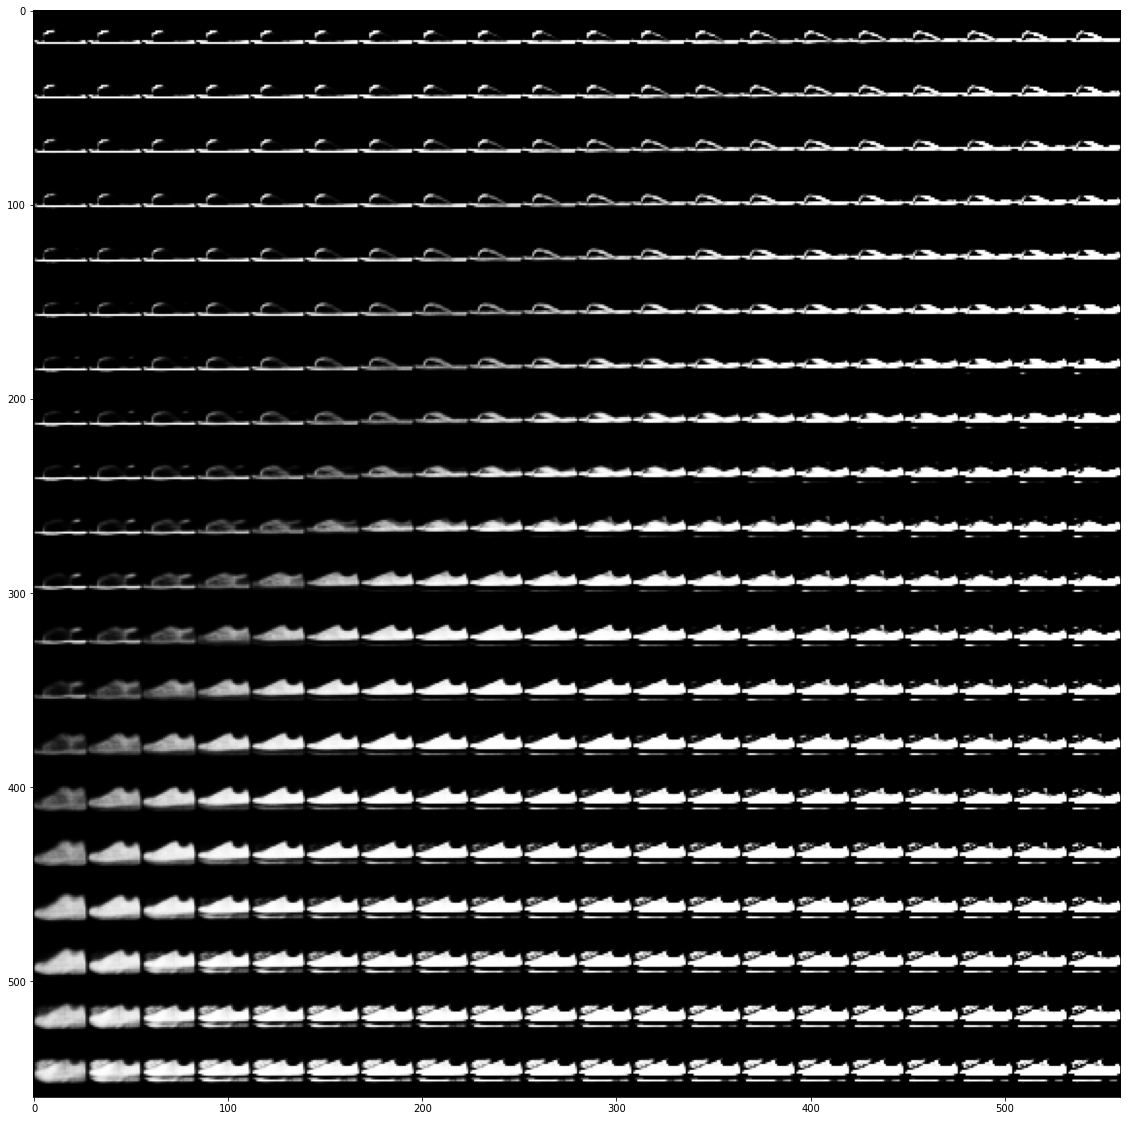

In [44]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show() 

# lec 21 

# Import all libraries

In [45]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

# Data pre-processing

In [46]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

# Set the latent space dimension

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

FileNotFoundError: ignored

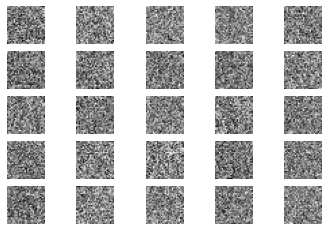

In [49]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)